# REDD Dataset Exploration

In [23]:
import numpy as np
import pandas as pd
import scipy as sp
from pathlib import Path
import matplotlib.pyplot as plt
import datetime
import math

## Import dataset

In [2]:
DATASET = Path("Datasets/REDD/low_freq/")
TARGET_HOUSE = "house_5"

In [3]:
house_dir = DATASET / TARGET_HOUSE
labels_file = house_dir / "labels.dat"
channel_files = list(house_dir.glob('channel_*.dat'))

** Available Appliances **

In [4]:
labels = pd.read_table(labels_file, sep = ' ', header = None, index_col = 0)
labels

,1
0,
1,mains
2,mains
3,microwave
4,lighting
5,outlets_unknown
6,furance
7,outlets_unknown
8,washer_dryer
9,washer_dryer


In [5]:
channels = None
for __channel_file in channel_files:
    __channel_n = __channel_file.stem.split('_')[1]
    __channel = pd.read_table(__channel_file, sep = ' ', names = ['' + labels[1][int(__channel_n)] + '@' + __channel_n], index_col = 0, parse_dates=True, date_parser=lambda t: datetime.datetime.fromtimestamp(int(t)))
    if channels is None:
        channels = __channel
    else:
        channels = pd.concat([channels, __channel], axis=1, join='inner')
del(__channel, __channel_n, __channel_file)


## Compare appliances over full dataset
Add applicance type to be plotted in the `TARGET_CHANNEL_NAMES` list

In [6]:
TARGET_CHANNEL_NAMES = ['mains', 'lighting', 'washer_dryer', 'refrigerator']

In [7]:
selected_channels = labels[labels[1].isin(TARGET_CHANNEL_NAMES)]
target_channels = (selected_channels[1] + '@' + selected_channels.index.astype(str)).tolist()
target_channels


['mains@1',
 'mains@2',
 'lighting@4',
 'washer_dryer@8',
 'washer_dryer@9',
 'lighting@14',
 'lighting@17',
 'refrigerator@18',
 'lighting@19',
 'lighting@23']

In [101]:
%matplotlib widget
channels.plot(y = target_channels, subplots = True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

## Single appliance study

In [111]:
TARGET_CHANNEL_NAME = 'refrigerator@18' #refrigerator@18
channel = channels[TARGET_CHANNEL_NAME]

### Compare different timespans of same appliance
Set applicance identifier `<appliance_label@channel_number>` to be plotted in the `TARGET_CHANNEL_NAME` variable

Add the `(<begin_date>, <end_date>)` tuples delimiting the to-be-compared timespans in the `INTERVALS` list

In [112]:
INTERVALS = [
    ('2011-05-23 00:00:00', '2011-05-24 00:00:00'), 
    ('2011-05-24 00:00:00', '2011-05-25 00:00:00')
]

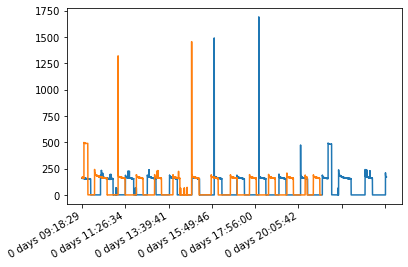

In [113]:
%matplotlib inline
timeseries = [(datetime.datetime.strptime(b, '%Y-%m-%d %H:%M:%S'), channel.loc[b:e]) for (b,e) in INTERVALS]
ax = None
for (b, ts) in timeseries:
    ts.index = ts.index - b
    if ax is None:
        ax = ts.plot()
    else:
        ts.plot(ax=ax)

### Value clustering

array([1.57272388e+02, 2.85908620e-01, 1.77654326e+02, 1.63467658e+02,
       1.98387698e+02, 4.91440491e+02, 1.69091596e+02, 6.16092437e+01])

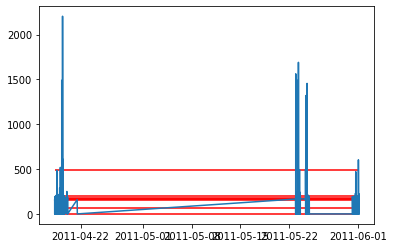

In [141]:
from scipy.cluster.vq import vq, kmeans, whiten

N_CLUSTER = 10

centroids, distortion = kmeans(channel.to_numpy(), N_CLUSTER)

plt.plot(channel)
plt.hlines(centroids, channel.index.min(), channel.index.max(), colors='r')

centroids

### Sample freq analysis

In [135]:
QUANTUM_SIZE = 1

channel_min = channel.min()
channel_max = channel.max()

quantized_channel = channel.apply(lambda v: math.floor(v / QUANTUM_SIZE) * QUANTUM_SIZE)

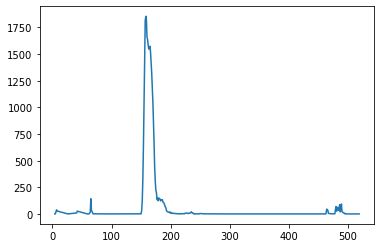

In [136]:
mask = (quantized_channel > 1) & (quantized_channel < 600)
channel_f = quantized_channel[mask].value_counts().sort_index()
plt.plot(channel_f.index, channel_f)

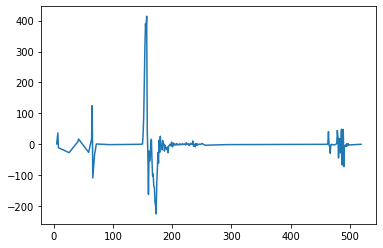

In [137]:
derivative = channel_f.diff() / QUANTUM_SIZE

plt.plot(derivative)

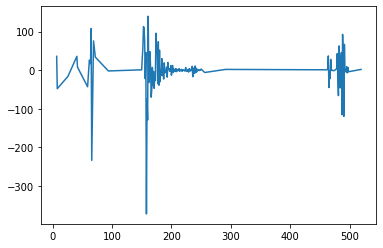

In [138]:
derivative2 = derivative.diff() / QUANTUM_SIZE

plt.plot(derivative2)